#FINAL PROJECT: PNEUMONIA IDENTIFICATION FROM X-RAY IMAGES
##Done by: Sara Curiel Manzanas, Juan Martínez-Aedo Castro & Candela Migoyo Bettoni

Pneumonia is an infection in one or both lungs, causing the air sacs of the lungs to fill with fluid or pus. Bacteria, viruses or fungi can cause pneumonia, and common symptoms include cough, fever, chills and shortness of breath. To diagnose pneumonia, physical examinations and diagnostic tests, such as a chest X-Ray, are usually performed.

Chest X-Rays are helpful in diagnosis because the presence of opacities in the lungs may indicate the fluid build-up or inflammation that is characteristic of pneumonia. In addition, pneumonia can affect the normal structure of the lungs (thickening of the alveolar septa or loss of definition of lung contours), which is reflected in changes in radiographic appearance.
For this reason, chest X-Ray images (anterior-posterior) from retrospective cohorts of paediatric patients aged one to five years were selected from the Guangzhou Medical Centre for Women and Children, Guangzhou, as part of the patient's routine clinical care.

Chest X-Ray classified as "normal" includes clear lungs with no areas of abnormal opacification on the image. Bacterial pneumonia typically shows focal lobar consolidation, in this case in the right upper lobe, while viral pneumonia manifests with a more diffuse "interstitial" pattern in both lungs.

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=dd7312c363724f6c5c808194bebd723fff726397095e922c12df474e0ef60b12
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PneumoniaIdentification").getOrCreate()

In [ ]:
spark

## 1. DEFINE DIRECTORIES, SHOW IMAGES AND STATISTICAL INFORMATION OF THE IMAGES
Define directory paths for training, test and validation data sets. For each directory, print information on the number of PNEUMONIA and NORMAL images. Also, visually display a pair of example images for each class in each directory using Matplotlib.


/content/drive/MyDrive/chest_xray/train --------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

/content/drive/MyDrive/chest_xray/test --------------------------------------------------------
PNEUMONIA=390
NORMAL=234

/content/drive/MyDrive/chest_xray/val --------------------------------------------------------
PNEUMONIA=8
NORMAL=8


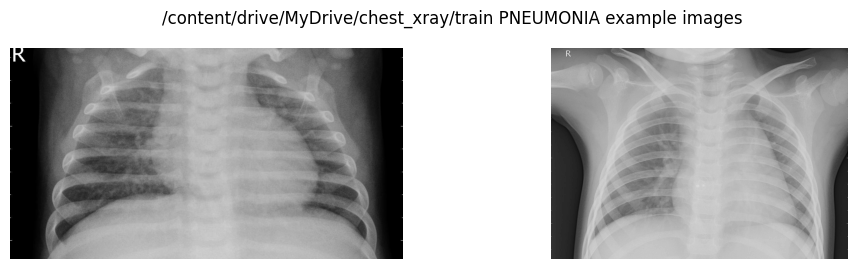

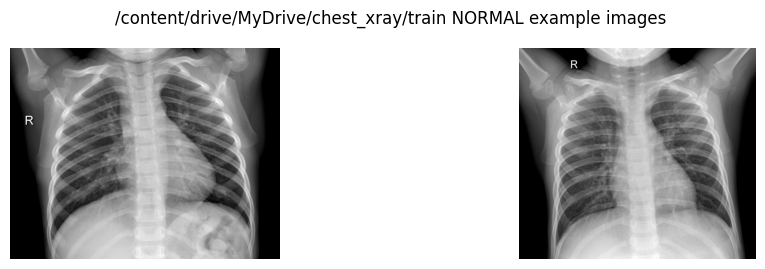

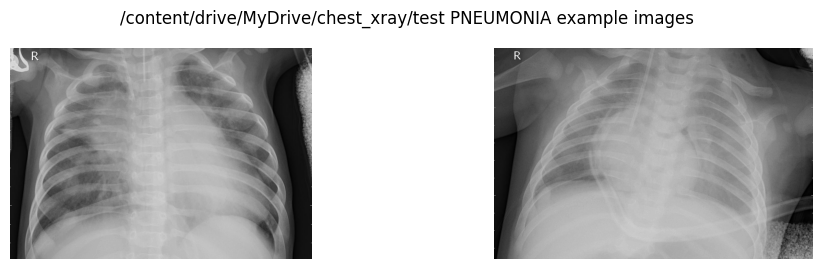

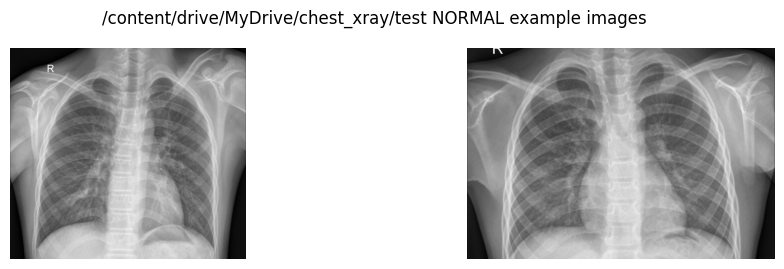

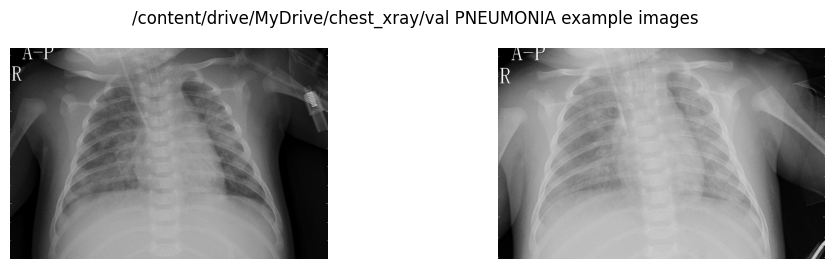

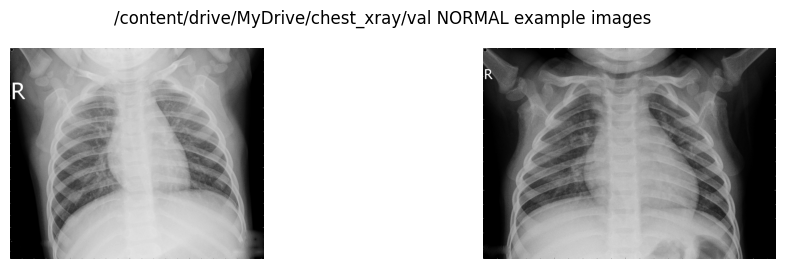

In [ ]:
# Define data paths
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"
val_dir = "/content/drive/MyDrive/chest_xray/val"

dir = [train_dir, test_dir, val_dir]

# Print a pair of images for each class and directory

for directory in dir:
    # Print directory separator
    print(f"\n{directory} --------------------------------------------------------")

    # Print the number of PNEUMONIA images in the current directory
    print(f"PNEUMONIA={len(os.listdir(os.path.join(directory, 'PNEUMONIA')))}")

    # Get a list of PNEUMONIA images and their directory
    pneumonia = os.listdir(os.path.join(directory, 'PNEUMONIA'))
    pneumonia_dir = os.path.join(directory, 'PNEUMONIA')

    # Create a subplot for PNEUMONIA images
    plt.figure(figsize=(10, 5))
    for i in range(2):
        plt.subplot(2, 2, i + 1)
        img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.suptitle(f"{directory} PNEUMONIA example images")
    plt.tight_layout()

    # Print the number of NORMAL images in the current directory
    print(f"NORMAL={len(os.listdir(os.path.join(directory, 'NORMAL')))}")

    # Get a list of NORMAL images and their directory
    normal = os.listdir(os.path.join(directory, 'NORMAL'))
    normal_dir = os.path.join(directory, 'NORMAL')

    # Create a subplot for NORMAL images
    plt.figure(figsize=(10, 5))
    for i in range(2):
        plt.subplot(2, 2, i + 1)
        img = plt.imread(os.path.join(normal_dir, normal[i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.suptitle(f"{directory} NORMAL example images")
        plt.tight_layout()


It is appreciated how images differ from the 'NORMAL' to the 'PNEUMONIA' ones. But, more interestingly for this job is how they all come in different shapes. We will redefine their size so they all fit into a frame where the illness is still clearly easy to idenify for the model. We generate pie charts to show the distribution of images of the NORMAL and PNEUMONIA classes in each directory (training, test and validation dataset). The objective is to visualise how the classes are distributed and to determine if an adjustment in the class weights is required to address an imbalance.

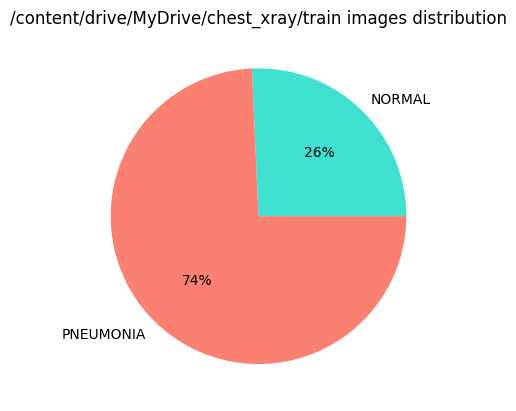

Weight for class 0 (normal): 0.74
Weight for class 1 (pneumonia): 0.26


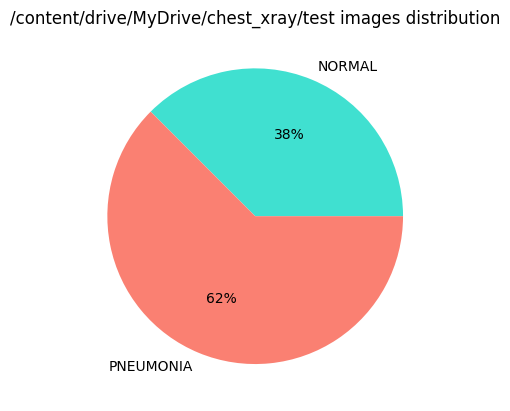

Weight for class 0 (normal): 0.62
Weight for class 1 (pneumonia): 0.38


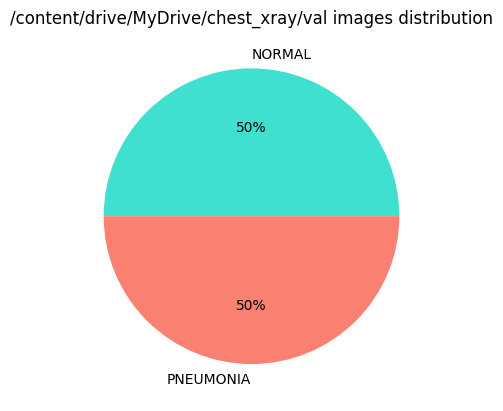

Weight for class 0 (normal): 0.50
Weight for class 1 (pneumonia): 0.50


In [ ]:
  # Plot the distribution for both types in each directory
for directory in dir:
    # Set the paths for NORMAL and PNEUMONIA directories
    normal_dir = os.path.join(directory, 'NORMAL')
    pneumonia_dir = os.path.join(directory, 'PNEUMONIA')

    # Get the number of images in each class
    num_normal = len(os.listdir(normal_dir))
    num_pneumonia = len(os.listdir(pneumonia_dir))

    # Create an array 'x' with counts for both NORMAL and PNEUMONIA classes
    x = np.array([len(os.listdir(normal_dir)), len(os.listdir(pneumonia_dir))])

    # Define labels and colors for the pie chart
    labels = ['NORMAL', 'PNEUMONIA']
    colors = {'NORMAL': 'turquoise', 'PNEUMONIA': 'salmon'}

    # Plot a pie chart to show the distribution of images for both classes
    plt.pie(x, labels=labels, autopct='%.0f%%', radius=1, colors=[colors[key] for key in labels], textprops={'fontsize': 10})
    plt.title(f"{directory} images distribution")
    plt.show()

    # Calculate class weights for balancing the dataset
    weight_normal = num_pneumonia / (num_normal + num_pneumonia)
    weight_pneumonia = num_normal / (num_normal + num_pneumonia)

    # Create a dictionary with class weights
    class_weight = {0: weight_normal, 1: weight_pneumonia}

    # Print the calculated class weights
    print(f"Weight for class 0 (normal): {weight_normal:.2f}")
    print(f"Weight for class 1 (pneumonia): {weight_pneumonia:.2f}")


We can see the percentage of each class (normal and pneumonia) in train, test and validation datasets

Now we are going to show the images with a colorbar indicating the intensity of the pixels.

Normal Image Information:
The dimensions of the image are 1577 pixels width and 2014 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 113.8051 and the standard deviation is 67.9693

Pneumonia Image Information:
The dimensions of the image are 576 pixels width and 1072 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 117.1600 and the standard deviation is 62.5687


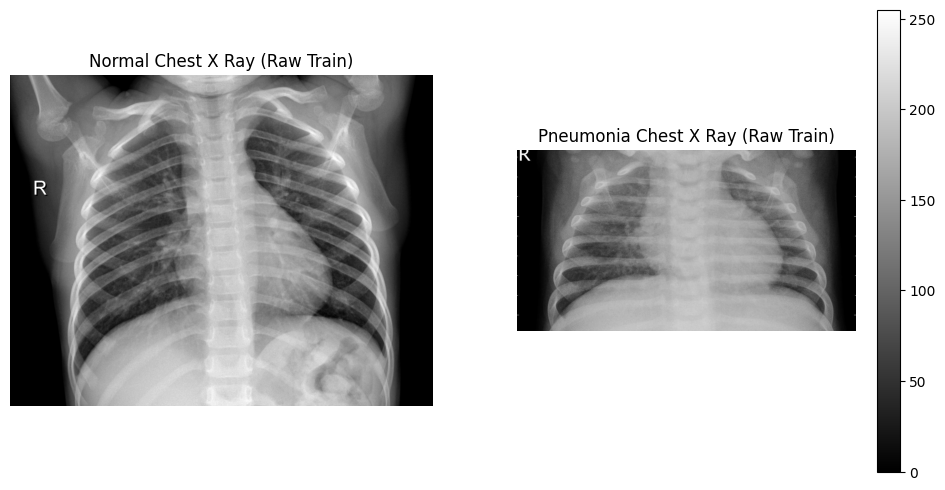

In [ ]:
# Displaying a normal image from the training set without modifications.
normal_img = os.listdir("/content/drive/MyDrive/chest_xray/train/NORMAL")[0]
normal_dir = "/content/drive/MyDrive/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))

# Displaying a pneumonia image from the training set without modifications.
pneumonia_img = os.listdir("/content/drive/MyDrive/chest_xray/train/PNEUMONIA")[0]
pneumonia_dir = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"
sample_img_pneumonia = plt.imread(os.path.join(pneumonia_dir, pneumonia_img))

# Plot both images on the same canvas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Normal Chest X Ray (Raw Train)')
axes[0].axis('off')

axes[1].imshow(sample_img_pneumonia, cmap='gray')
axes[1].set_title('Pneumonia Chest X Ray (Raw Train)')
axes[1].axis('off')

# Display information about the normal image
print(f"Normal Image Information:")
print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Display information about the pneumonia image
print(f"\nPneumonia Image Information:")
print(f"The dimensions of the image are {sample_img_pneumonia.shape[0]} pixels width and {sample_img_pneumonia.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img_pneumonia.max():.4f} and the minimum is {sample_img_pneumonia.min():.4f}")
print(f"The mean value of the pixels is {sample_img_pneumonia.mean():.4f} and the standard deviation is {sample_img_pneumonia.std():.4f}")

# Show the plot
plt.imshow(sample_img_pneumonia,cmap='gray')
plt.colorbar()

plt.show()


We use Seaborn to plot histograms of the pixel intensities of a normal image and a pneumonia image. Two vertical subplots are created, each showing the distribution of pixel intensities for their respective image, and labels are included with the mean and standard deviation of the intensities. This provides a visual representation of how the pixel intensities vary in the X-ray images.

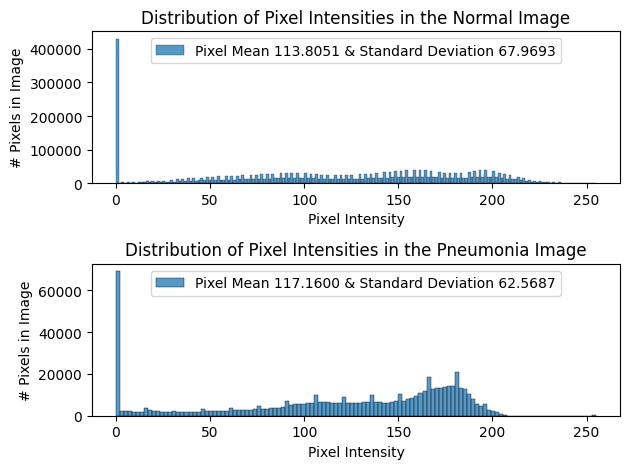

In [ ]:
# Plotting pixel intensities for the normal image
plt.subplot(2, 1, 1)  # 2 rows, 1 column, position 1
sns.histplot(sample_img.ravel(), label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Normal Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Plotting pixel intensities for the pneumonia image
plt.subplot(2, 1, 2)  # 2 rows, 1 column, position 2
sns.histplot(sample_img_pneumonia.ravel(), label=f"Pixel Mean {np.mean(sample_img_pneumonia):.4f} & Standard Deviation {np.std(sample_img_pneumonia):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Pneumonia Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


From the plots above, correspondant to both the images displayed previously, it is noticeable how the 'PNEUMONIA' one shows far more clearer pixels (with higher intensities, i.e., closer to white pixels) than the 'NORMAL' one. This follows what we expect if we take a look at the pairs of 'NORMAL' and 'PNEUMONIA' images shown before for each of the directories, where the illness seems to be represented as images where the toracic box has more gray-ish pixels, as if representing blurrier images or more noisy ones in that zone.

Additionally, the plots for both images reflect a very high number of pixels with an intensity of 0 (black). This is thought to be because of the plotting of a black background.

# 2. DATA TRANSFORMATION OF THE IMAGES
We use a Keras image data generator to apply data augmentation techniques, such as rotation, translation, shear and zoom, to the training set. The main objective is to improve the generalisability of the model by applying various transformations to the training images. This helps the model to learn more robust patterns and to be more resilient to variations in the data during training and, eventually, in the application of the model to new data.

In addition, we display statistical information about the generated image, including dimensions, maximum and minimum pixel values, mean and standard deviation. Finally, we plot a histogram of the pixel intensities in the generated image to provide a visual representation of the intensity distribution.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Image data generator configuration
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Generate images for every directory
train=image_generator.flow_from_directory(train_dir,batch_size=8,shuffle=True,class_mode='binary',target_size=(180,180))
validation = image_generator.flow_from_directory(val_dir,batch_size=1,shuffle=False,class_mode='binary',target_size=(180, 180))
test = image_generator.flow_from_directory(test_dir,batch_size=1,shuffle=False,class_mode='binary', target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.0346 and the minimum is -3.3578
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


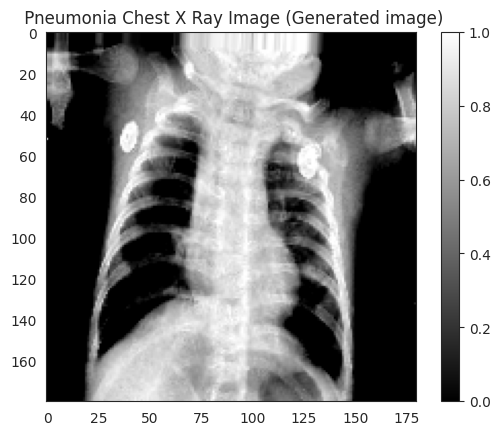

In [ ]:
# Plot an example of the processed images
sns.set_style('white')  # Set Seaborn style to white background
generated_image, label = train.__getitem__(0)  # Get a generated image and its label
plt.imshow(generated_image[0], cmap='gray')  # Display the generated image
plt.colorbar()  # Add a colorbar

# Determine the label message based on the binary label
if label[0] == 0.:
  message = "Normal"
else:
  message = "Pneumonia"

plt.title(f' {message} Chest X Ray Image (Generated image)')  # Include label in the title

# Print information about the generated image
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

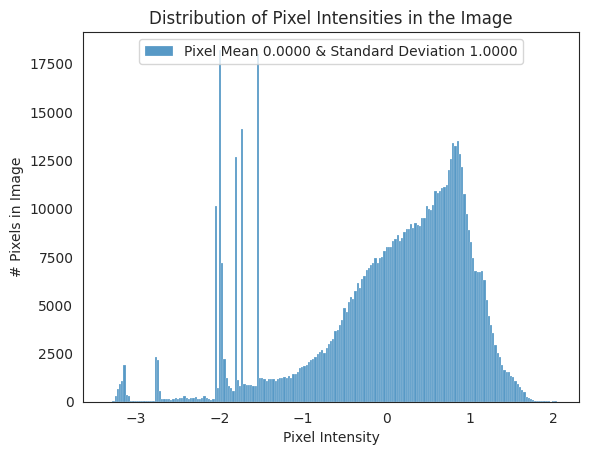

In [ ]:
# Plot a histogram of pixel intensities in the generated image
sns.histplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')  # Add legend to the upper center of the plot
plt.title('Distribution of Pixel Intensities in the Image')  # Set the title of the plot
plt.xlabel('Pixel Intensity')  # Set the label for the x-axis
plt.ylabel('# Pixels in Image')  # Set the label for the y-axis

Here, the intensies for the pixels are way different than those plotted for the raw pneumonia image. The variation in the scale of the pixels (from 0 to 250 to -3 to 3) in the histogram after applying the ImageDataGenerator is due to the normalization performed during image processing.

# 3. MODEL WITH RANDOM-FOREST
Random Forest is a machine learning model used for classification and regression tasks. This model builds multiple decision trees during training, combining their results to improve accuracy and reduce overfitting. It is versatile, handles feature importance, and is applied in a variety of fields, providing accurate predictions in complex problems.

We use a RandomForest classifier from scikit-learn to train and evaluate a model using the generated images.

In [ ]:
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier from scikit-learn
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn.metrics import accuracy_score, classification_report  # Import metrics for evaluation

num_batches_train = len(train)
all_generated_images_train = []  # Initialize a list to store generated images
all_labels_train = []  # Initialize a list to store labels

# Iterate through batches in the training set
for i in range(num_batches_train):
    generated_images_train, labels_train = train.__getitem__(i)  # Get generated images and labels
    all_generated_images_train.append(generated_images_train)  # Append to the list
    all_labels_train.append(labels_train)  # Append to the list

all_generated_images_train = np.vstack(all_generated_images_train)  # Concatenate generated images
all_labels_train = np.concatenate(all_labels_train)  # Concatenate labels

# Flatten the images
all_generated_images_train_flattened = all_generated_images_train.reshape(all_generated_images_train.shape[0], -1)

In [ ]:
# Get the number of batches in the test set
num_batches_test = len(test)

all_generated_images_test = []  # Initialize a list to store generated images for testing
all_labels_test = []  # Initialize a list to store labels for testing

# Iterate through batches in the test set
for i in range(num_batches_test):
    generated_images_test, labels_test = test.__getitem__(i)  # Get generated images and labels for testing
    all_generated_images_test.append(generated_images_test)  # Append to the list
    all_labels_test.append(labels_test)  # Append to the list

all_generated_images_test = np.vstack(all_generated_images_test)  # Concatenate generated images for testing
all_labels_test = np.concatenate(all_labels_test)  # Concatenate labels for testing

# Flatten the images for testing
all_generated_images_test_flattened = all_generated_images_test.reshape(all_generated_images_test.shape[0], -1)

In [ ]:
# Assign variables for training and testing datasets
X_train = all_generated_images_train_flattened  # Features for training
y_train = all_labels_train  # Labels for training
X_test = all_generated_images_test_flattened  # Features for testing
y_test = all_labels_test  # Labels for testing

We create a Random Forest classifier with 100 trees and a fixed random state. We train the model using the training data (X_train and y_train), and then calculate the accuracy of the model on the test set (X_test and y_test) and print the result.

In [ ]:
# Create a RandomForestClassifier with 100 trees and a fixed random state
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Calculate the accuracy on the test set using the trained RandomForestClassifier
accuracy = rf_classifier.score(X_test, y_test)

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.79


Once our random forest model has been run, the result obtained for the accuracy in the evaluation of the predictions is of nearly 80%. This means that only a few of the images (20 out of 100) will be wrongly classified into pneumonia or normal.

We perform the prediction of each image in the test set (X_test) using the previously trained Random Forest classifier (rf_classifier). The prediction results together with the actual labels are converted into a pandas DataFrame called results_df.

In [ ]:
import pandas as pd

# Create a list to store the results
results = []

# Make predictions for each image in X_test
for idx in range(len(X_test)):
    image_to_predict = X_test[idx].reshape(1, -1)
    prediction = rf_classifier.predict(image_to_predict)[0]

    # Store the results in the list
    results.append({'ImageIndex': idx, 'Prediction': prediction, 'ActualLabel': y_test[idx]})

# Convert the list to a pandas DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame
results_df.head()

,ImageIndex,Prediction,ActualLabel
0,0,1.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,1.0,0.0


We use an evaluator (BinaryClassificationEvaluator) to calculate the area under the ROC curve metric (areaUnderROC) using the DataFrame results_df, which contains the predictions

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a BinaryClassificationEvaluator with specified columns
evaluator = BinaryClassificationEvaluator(rawPredictionCol='Prediction', labelCol='ActualLabel')

results_random_forest = spark.createDataFrame(results_df)
# Evaluate the results DataFrame using the area under the ROC curve metric
areaUnderRoc_random=evaluator.evaluate(results_random_forest, {evaluator.metricName: "areaUnderROC"})
print("The area under the ROC curve metric of this model done with Random Forest is :", areaUnderRoc_random)

The area under the ROC curve metric of this model done with Random Forest is : 0.732905982905983


The random forest model reaches a good enough value for the accuracy but it is considered that maybe using a deep learning approach would also be benefitial in this case. Thus, we are implementing a neuronal network too. Some of the reasons behind this decision are:
* Convolutional Neural Networks (CNNs) are a common choice for this type of image classifications, since most of the literature is based on using deep learning to do so.
* CNNs are specifically designed to work with image data and can capture spatial and local relationship patterns.
* CNNs can efficiently handle this the high number of pixels thanks to their architecture, which shares parameters and reduces the number of trainable parameters compared to more traditional approaches.

In summary, CNNs are particularly powerful and effective for image classification tasks due to their ability to capture spatial patterns, translation invariance, feature hierarchy, and efficient handling of high-dimensional data.

Furthermore, no pre-trained methods have been implemented for the present job, since the reviewed literature reportedly compared the different use of some of them to the use of neuronal networks and the latter were always considered more accurate and reliable.

# 4. CNN MODEL USING KERAS FROM TENSORFLOW (DEEP LEARNING)

We define a convolutional neural network (CNN) in Keras to identify pneumonia in X-ray images. The CNN consists of convolutional layers, batch normalisation, maximum clustering and fully connected layers. Binary cross-entropy loss function, the Adam optimiser and accuracy monitoring are used. A scheduler dynamically adjusts the learning rate during training.

In [ ]:
# Use BigDL Keras CNN
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(180,180,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(180,180,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
optimizer='adam'
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                        

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 5.6490 - accuracy: 0.7912

100/100 [==============================] - 178s 2s/step - loss: 5.6490 - accuracy: 0.7912 - val_loss: 6.5189 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7700

100/100 [==============================] - 158s 2s/step - loss: 0.5975 - accuracy: 0.7700 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.8025

100/100 [==============================] - 156s 2s/step - loss: 0.2053 - accuracy: 0.8025 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.8188

100/100 [==============================] - 156s 2s/step - loss: 0.2050 - accuracy: 0.8188 - lr: 0.0010
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.8300

100/100 [==============================] - 160s 2s/step - loss: 0.1815 - accuracy: 0.8300 - lr: 0.0010
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.8500

100/100 [==============================] - 160s 2s/step - loss: 0.1876 - accuracy: 0.8500 - lr: 0.0010
Epoch 7/10
100/100 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.8800

100/100 [==============================] - 156s 2s/step - loss: 0.1770 - accuracy: 0.8800 - lr: 0.0010
Epoch 8/10
100/100 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.8925

100/100 [==============================] - 160s 2s/step - loss: 0.1615 - accuracy: 0.8925 - lr: 0.0010
Epoch 9/10
100/100 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9038

100/100 [==============================] - 155s 2s/step - loss: 0.1392 - accuracy: 0.9038 - lr: 0.0010
Epoch 10/10
100/100 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.8850

100/100 [==============================] - 157s 2s/step - loss: 0.1417 - accuracy: 0.8850 - lr: 0.0010


Text(0.5, 1.0, 'Accuracy Evolution')

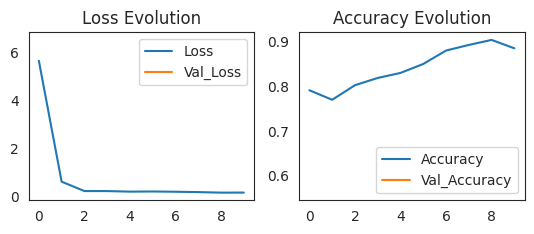

In [ ]:
# Train the model
# Validation set is used as a pre-test comprobation, to make sure the model is good enough before finally applying the test set to it.
r=model.fit(
                 train,epochs=10,validation_data=validation,class_weight=class_weight,steps_per_epoch=100,validation_steps=25,callbacks=[scheduler]
)

# Print the loss function and the reached accuracy during the process
plt.subplot(2,2,1)
plt.plot(r.history['loss'],label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

The plots depicted above show the functions for the loss and accuracy througout the different epochs run. Albeit firstly having a higher loss and a worse accuracy, the model develops to reach a nearly 0 loss and a very high accuracy (about 90%), too. This shows that, although being a simple neuronal network, the results obtained from it are good enough.

It is important to notice that when running excessively simple neuronal networks the model tends to make an overfitting, which would yield very good results but that are not actually reliable. This way, we have decided to apply a moderate number of layers. The ones that are commented ('#') in the code have been considered to be left out since the metrics for the predictions were nearly the same without them.

In [ ]:
import pandas as pd
# Evaluate the model
evaluation=model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

# Show the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

pred=model.predict(test)
print(confusion_matrix(test.classes,pred>0.5))
pd.DataFrame(classification_report(test.classes ,pred >0.5,output_dict=True))

624/624 [==============================] - 37s 59ms/step - loss: 0.8472 - accuracy: 0.8413
Test Accuracy: 84.13%
652/652 [==============================] - 256s 391ms/step - loss: 0.2828 - accuracy: 0.9199
Train Accuracy: 91.99%
624/624 [==============================] - 39s 63ms/step
[[166  68]
 [ 24 366]]


,0,1,accuracy,macro avg,weighted avg
precision,0.873684,0.843318,0.852564,0.858501,0.854705
recall,0.709402,0.938462,0.852564,0.823932,0.852564
f1-score,0.783019,0.888350,0.852564,0.835684,0.848851
support,234.000000,390.000000,0.852564,624.000000,624.000000


In [ ]:
import pandas as pd

# Create a list to store the results
results = []

# Make predictions for each image in X_test
for idx in range(len(X_test)):
    prediction = pred[idx]

    # Store the results in the list
    results.append({'ImageIndex': idx, 'Prediction': prediction, 'ActualLabel': y_test[idx]})

# Convert the list to a pandas DataFrame
results_df_keras = pd.DataFrame(results)

# Print the DataFrame
results_df_keras

,ImageIndex,Prediction,ActualLabel
0,0,[0.44003466],0.0
1,1,[0.44003466],0.0
2,2,[0.44003466],0.0
3,3,[0.69228864],0.0
4,4,[0.44003466],0.0
...,...,...,...
619,619,[1.0],1.0
620,620,[1.0],1.0
621,621,[0.981218],1.0
622,622,[0.99898905],1.0


Finally, when analysing the evaluation for our neuronal network model, it is observed how good the accuracy level reached is (84.13% for the test set and 91.99% for the training set). The values obtained for the loss function are also low (0.8472 for the test set and 0.2828 for the training one).

Additionaly, the confussion matrix is also printed above, where the numbers of the diagonal show how there are some false positives/negatives (top right/bottom left, respectively) but these are relatively low for the total number of the samples.

The parameters shown in the table right below the confussion matrix are also good for this model, with fairly acceptable values for the precision, recall, f1-score and support, as they can be seen in said table.

#DOCUMENTATION:
- Kaggle website with the data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- Bigdl Documentation:
  - https://bigdl.readthedocs.io/en/latest/
  - https://bigdl.readthedocs.io/en/latest/doc/DLlib/QuickStart/python-getting-started.html
  - https://bigdl-project.github.io/0.5.0/
- Keras (BigDL): https://analytics-zoo.readthedocs.io/en/latest/doc/UseCase/keras-api.html
- Random Forest Classifier:
  - https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial
  - https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial
- https://www.mdpi.com/2075-4418/13/3/551
- https://arxiv.org/pdf/1711.05225.pdf
- https://github.com/zoogzog/chexnet/commit/34d29eeee52a620dc274e78932454c6983aee62f

